# Lab 2: Sentiment Analysis in Apache Spark

*   NEO ZHENG WENG A22EC0093
*   [Youtube Tutorial](https://www.youtube.com/watch?v=D4Z-r69Xj2Q)



In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import when, col

from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, StringIndexer

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# Create SparkSession
spark = SparkSession.builder \
    .appName("Sentiment Analysis") \
    .master("local[*]") \
    .getOrCreate()

In [3]:
# Load data
data = spark.read \
    .option("header", False) \
    .option("inferSchema", True) \
    .csv("/content/twitter_training.csv")

In [4]:
data.show()

+----+-----------+--------+--------------------+
| _c0|        _c1|     _c2|                 _c3|
+----+-----------+--------+--------------------+
|2401|Borderlands|Positive|im getting on bor...|
|2401|Borderlands|Positive|I am coming to th...|
|2401|Borderlands|Positive|im getting on bor...|
|2401|Borderlands|Positive|im coming on bord...|
|2401|Borderlands|Positive|im getting on bor...|
|2401|Borderlands|Positive|im getting into b...|
|2402|Borderlands|Positive|So I spent a few ...|
|2402|Borderlands|Positive|So I spent a coup...|
|2402|Borderlands|Positive|So I spent a few ...|
|2402|Borderlands|Positive|So I spent a few ...|
|2402|Borderlands|Positive|2010 So I spent a...|
|2402|Borderlands|Positive|                 was|
|2403|Borderlands| Neutral|Rock-Hard La Varl...|
|2403|Borderlands| Neutral|Rock-Hard La Varl...|
|2403|Borderlands| Neutral|Rock-Hard La Varl...|
|2403|Borderlands| Neutral|Rock-Hard La Vita...|
|2403|Borderlands| Neutral|Live Rock - Hard ...|
|2403|Borderlands| N

In [5]:
# Clean data
# Clean the data
data = (
    data
    .drop("_c0", "_c1")  # Drop unnecessary columns
    .filter(
        (col("_c2").isNotNull()) & (col("_c2") != '') &  # Remove rows where sentiment is null or empty
        (col("_c3").isNotNull()) & (col("_c3") != '')  # Remove rows where text is null or empty
    )
    .withColumnRenamed("_c2", "sentiment")  # Rename _c2 to "sentiment"
    .withColumnRenamed("_c3", "text")      # Rename _c3 to "text"
)

data.printSchema()
data.show()

root
 |-- sentiment: string (nullable = true)
 |-- text: string (nullable = true)

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
| Positive|im getting on bor...|
| Positive|I am coming to th...|
| Positive|im getting on bor...|
| Positive|im coming on bord...|
| Positive|im getting on bor...|
| Positive|im getting into b...|
| Positive|So I spent a few ...|
| Positive|So I spent a coup...|
| Positive|So I spent a few ...|
| Positive|So I spent a few ...|
| Positive|2010 So I spent a...|
| Positive|                 was|
|  Neutral|Rock-Hard La Varl...|
|  Neutral|Rock-Hard La Varl...|
|  Neutral|Rock-Hard La Varl...|
|  Neutral|Rock-Hard La Vita...|
|  Neutral|Live Rock - Hard ...|
|  Neutral|I-Hard like me, R...|
| Positive|that was the firs...|
| Positive|this was the firs...|
+---------+--------------------+
only showing top 20 rows



In [6]:
# Use StringIndexer to convert the sentiment column into numeric labels
indexer = StringIndexer(inputCol="sentiment", outputCol="label")

# Fit and transform the data to create the 'label' column
data = indexer.fit(data).transform(data)

data.printSchema()
data.show()

root
 |-- sentiment: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: double (nullable = false)

+---------+--------------------+-----+
|sentiment|                text|label|
+---------+--------------------+-----+
| Positive|im getting on bor...|  1.0|
| Positive|I am coming to th...|  1.0|
| Positive|im getting on bor...|  1.0|
| Positive|im coming on bord...|  1.0|
| Positive|im getting on bor...|  1.0|
| Positive|im getting into b...|  1.0|
| Positive|So I spent a few ...|  1.0|
| Positive|So I spent a coup...|  1.0|
| Positive|So I spent a few ...|  1.0|
| Positive|So I spent a few ...|  1.0|
| Positive|2010 So I spent a...|  1.0|
| Positive|                 was|  1.0|
|  Neutral|Rock-Hard La Varl...|  2.0|
|  Neutral|Rock-Hard La Varl...|  2.0|
|  Neutral|Rock-Hard La Varl...|  2.0|
|  Neutral|Rock-Hard La Vita...|  2.0|
|  Neutral|Live Rock - Hard ...|  2.0|
|  Neutral|I-Hard like me, R...|  2.0|
| Positive|that was the firs...|  1.0|
| Positive|this was t

In [7]:
# Manually adjust the numeric labels after transformation
data = data.withColumn(
    "label",
    when(data["sentiment"] == "Negative", 0)
    .when(data["sentiment"] == "Neutral", 1)
    .when(data["sentiment"] == "Positive", 2)
    .when(data["sentiment"] == "Irrelevant", 3)
    .otherwise(data["label"])  # Keep the original label if not matching
)

data.show()

+---------+--------------------+-----+
|sentiment|                text|label|
+---------+--------------------+-----+
| Positive|im getting on bor...|  2.0|
| Positive|I am coming to th...|  2.0|
| Positive|im getting on bor...|  2.0|
| Positive|im coming on bord...|  2.0|
| Positive|im getting on bor...|  2.0|
| Positive|im getting into b...|  2.0|
| Positive|So I spent a few ...|  2.0|
| Positive|So I spent a coup...|  2.0|
| Positive|So I spent a few ...|  2.0|
| Positive|So I spent a few ...|  2.0|
| Positive|2010 So I spent a...|  2.0|
| Positive|                 was|  2.0|
|  Neutral|Rock-Hard La Varl...|  1.0|
|  Neutral|Rock-Hard La Varl...|  1.0|
|  Neutral|Rock-Hard La Varl...|  1.0|
|  Neutral|Rock-Hard La Vita...|  1.0|
|  Neutral|Live Rock - Hard ...|  1.0|
|  Neutral|I-Hard like me, R...|  1.0|
| Positive|that was the firs...|  2.0|
| Positive|this was the firs...|  2.0|
+---------+--------------------+-----+
only showing top 20 rows



In [8]:
# create a Tokenizer that reads “text” and outputs an array column “words”
tokenizer = Tokenizer(inputCol="text", outputCol="words")

# apply it to DataFrame
data = tokenizer.transform(data)

# now `data` has a new column “words” containing the tokenized text
data.select("text", "words").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                 |words                                                       

In [9]:
# Create a StopWordsRemover that reads “words” and writes “filtered”
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# Apply it to your DataFrame
data = remover.transform(data)

# Now `data` has a new column “filtered” (tokens minus English stopwords)
data.select("words", "filtered").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words                                                                                                                                                                                                                                                                                                                                                       |filtered                                                              

In [10]:
# Create a CountVectorizer that reads “filtered” and writes “features”
vectorizer = CountVectorizer(inputCol="filtered", outputCol="features")

# Fit on DataFrame (this learns the vocabulary from “filtered” tokens)
vector_model = vectorizer.fit(data)

# Transform the DataFrame: add a “features” column (sparse vector)
data = vector_model.transform(data)

data.select("filtered", "features").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered                                                                                                                                                                                                                            |features                                                                                                                                                                                                                                 |
+---------------------------------------------------------------------

In [11]:
# Split 8/2 training and testing data
training_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [12]:
# Create a LogisticRegression object
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Train the model on the training data
model = lr.fit(training_data)

# Use the trained model to make predictions on the test data
predictions = model.transform(test_data)

In [13]:
# Create the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",           # True label column
    predictionCol="prediction", # Predicted label column
    metricName="accuracy"       # Metric we want to evaluate (accuracy)
)

# Evaluate the model's accuracy
accuracy = evaluator.evaluate(predictions)

print(f"Test Set Accuracy = {accuracy:.4f}")

Test Set Accuracy = 0.8403


In [14]:
# Show the predicted data
predictions.select("text", "label", "prediction").show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------+-----+----------+
|text                                                                                                   |label|prediction|
+-------------------------------------------------------------------------------------------------------+-----+----------+
|                                                                                                       |3.0  |2.0       |
|                                                                                                       |3.0  |2.0       |
|                                                                                                       |3.0  |2.0       |
|                                                                                                       |3.0  |2.0       |
|                                                                                                       |3.0  |2.0       |
|               

In [16]:
# Create confusion matrix by grouping by 'label' and 'prediction'
confusion_matrix = predictions.groupBy("label", "prediction").count()

confusion_matrix.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|  235|
|  1.0|       1.0| 2879|
|  3.0|       2.0|  206|
|  0.0|       1.0|  167|
|  1.0|       0.0|  216|
|  2.0|       2.0| 3651|
|  3.0|       1.0|  119|
|  2.0|       3.0|  160|
|  2.0|       1.0|  164|
|  1.0|       2.0|  337|
|  0.0|       0.0| 3876|
|  1.0|       3.0|  161|
|  0.0|       2.0|  306|
|  3.0|       3.0| 2014|
|  0.0|       3.0|  145|
|  3.0|       0.0|  144|
+-----+----------+-----+



In [17]:
# Convert the confusion matrix to a Pandas DataFrame
conf_matrix_pdf = confusion_matrix.toPandas()

# Pivot the DataFrame to get it in the form of a matrix
conf_matrix_pivot = conf_matrix_pdf.pivot(index='label', columns='prediction', values='count').fillna(0)

print(conf_matrix_pivot)

prediction   0.0   1.0   2.0   3.0
label                             
0.0         3876   167   306   145
1.0          216  2879   337   161
2.0          235   164  3651   160
3.0          144   119   206  2014


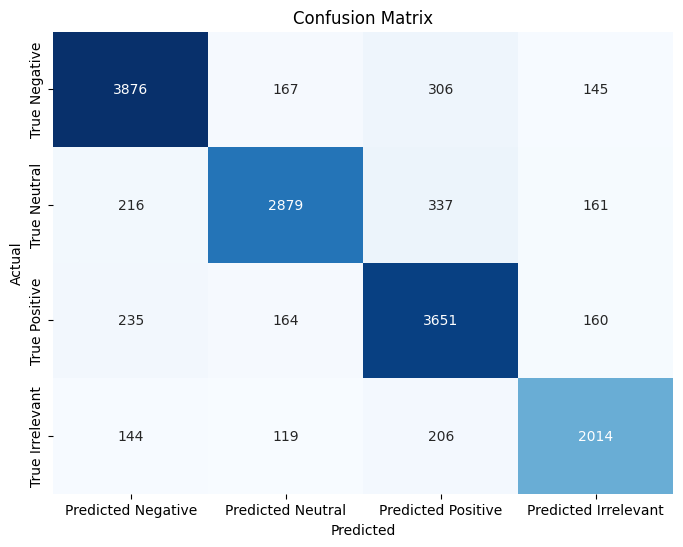

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pivot, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Neutral", "Predicted Positive", "Predicted Irrelevant"],
            yticklabels=["True Negative", "True Neutral", "True Positive", "True Irrelevant"])

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
# Save the trained model
model.write().overwrite().save("sentiment_model")